In [2]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from subprocess import call
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import export_graphviz

from definitions import GEN_PATH, ROOT_DIR

sns.set_context('notebook')
sns.set_style('white')

In [3]:
# Load data and process data set
with open(os.path.join(ROOT_DIR, 'config.json')) as f:
    config = json.load(f)

proc_match_filepath = os.path.join(GEN_PATH, config['proc_match_filename'])

# Read data
data = pd.read_hdf(proc_match_filepath, key='matches')

# Remove unwanted features and NaNs
drop_cols_first = ['player_1', 'player_2', 'home_advantage', 'surface', 'mutual_games', 'mutual_wins', 'rel_climate_wins', 'rel_total_wins', 'mutual_surface_wins', 'age_diff', 'rel_recent_wins']
# drop_cols_first = ['mutual_wins', 'mutual_surface_wins', 'surface', 'home_advantage', 'rel_climate_wins', 'rel_total_wins', 'mutual_games', 'rel_surface_wins']
drop_cols_second = ['outcome', 'tourney_date', 'tourney_level']
data.drop(drop_cols_first, axis=1, inplace=True)
data.dropna(inplace=True)

# Split data set into train and test
# Start of 2019 season in unix time, 2018-12-31 00:00:00 UTC
test_date_begin = 1546214400

# Testing will be done on 2019 matches
data_train = data.loc[data.tourney_date < test_date_begin]
data_train.reset_index(inplace=True, drop=True)
y_train = data_train.outcome
X_train = data_train.drop(drop_cols_second, axis=1)

display(X_train)

data_test = data.loc[data.tourney_date >= test_date_begin]
data_test.reset_index(inplace=True, drop=True)
y_test = data_test.outcome
tourney_level_test = data_test.tourney_level

level_map = config['tourney_levels']
points_map = config['match_points']

# Extract number prediction points from match
def get_points(level):
    for key, value in level_map.items():
        if value == level:
            return points_map[key]

tourney_level_test = tourney_level_test.apply(get_points, convert_dtype=True)

X_test = data_test.drop(drop_cols_second, axis=1)

# Number of folds to use in cross-validation
cvs = 5

rel_surface_wins  rank_diff  points_grad_diff  rel_tourney_games
0              0.420512   0.298397         -0.156014           0.000408
1             -0.512297  -0.083118          0.449323           0.000408
2             -0.139173  -0.012353          0.015972           0.000408
3             -0.605578   0.070719         -0.057156           0.000408
4             -2.797680   1.355255         -0.183099           0.000408
...                 ...        ...               ...                ...
91603          1.633165  -0.738462          0.028160           0.000408
91604          0.607074  -0.576933          0.085037           0.000408
91605         -1.305185   2.625945         -0.181744           0.000408
91606         -0.419016   0.241478         -0.063927           0.000408
91607          0.327231  -0.369254          0.013264           0.000408

[91608 rows x 4 columns]

/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

        -1.0       0.72      0.73      0.73     15016
         1.0       0.73      0.73      0.73     15215

    accuracy                           0.73     30231
   macro avg       0.73      0.73      0.73     30231
weighted avg       0.73      0.73      0.73     30231



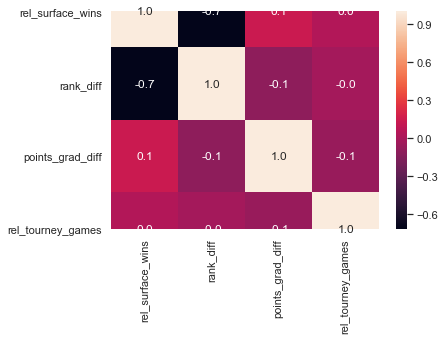

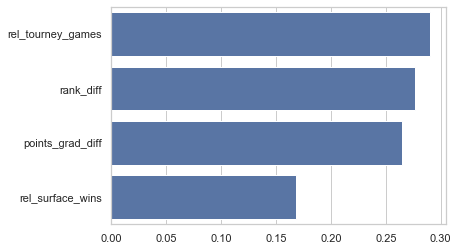

In [7]:
# Run base model static split, RandomForest
Xv_train, Xv_val, yv_train, yv_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

model = RandomForestClassifier(max_depth=10)
model.fit(Xv_train, yv_train)

full_val_pred = model.predict(Xv_val)
class_report_full = classification_report(yv_val, full_val_pred)
print(class_report_full)

sns.heatmap(Xv_train.corr(), annot=True, fmt='.1f')
plt.show()

sns.set(style="whitegrid")
feat_imp = pd.Series(model.feature_importances_, index=Xv_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)
sns.barplot(x=feat_imp.to_list(), y=feat_imp.index, color='b')
plt.show()

In [25]:
# Evaluate Random Forest with CV
rf_model = RandomForestClassifier(max_depth=10)
scores = cross_val_score(rf_model, X_train, y_train, cv=cvs)
print("RandomForest accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Jon/opt/anaconda3/lib/python3

RandomForest accuracy: 0.73 (+/- 0.01)


In [71]:
# Evaluate kNN with CV

k = len(X_train) ** 0.5
knn_model = KNeighborsClassifier()
scores = cross_val_score(knn_model, X_train, y_train, cv=cvs)
print("kNN accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

kNN accuracy: 0.69 (+/- 0.01)


In [72]:
# Evaluate SVM with CV
# Takes forever to train, at least 5 minutes

C = 1
kernel = 'rbf'
svm_model = SVC(C, kernel)
scores = cross_val_score(svm_model, X_train, y_train, cv=cvs)
print("SVM accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

SVM accuracy: 0.73 (+/- 0.01)


In [20]:
# Evaluate neural network with CV
hidden_layer_sizes = (6,)
activation = 'logistic'
alpha = 0.0001
nn_model = MLPClassifier(hidden_layer_sizes, activation, alpha=alpha)

scores = cross_val_score(nn_model, X_train, y_train, cv=cvs)
print("Neural Network accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Neural Network accuracy: 0.73 (+/- 0.01)


In [4]:
# Logistic regression with CV

lr_model = LogisticRegression(solver='lbfgs')
lr_model.fit(X_train, y_train)
print(X_train.columns)
print(lr_model.coef_)
scores = cross_val_score(lr_model, X_train, y_train, cv=cvs)
print("Logistic Regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Index(['rel_surface_wins', 'rank_diff', 'points_grad_diff',
       'rel_tourney_games'],
      dtype='object')
[[ 0.3773152  -0.74956808  0.51291142  0.7134152 ]]
Logistic Regression accuracy: 0.72 (+/- 0.01)


In [20]:
# Logistic regression, baseline

X_train_base = X_train.filter(['rank_diff'])

lr_model = LogisticRegression(solver='lbfgs')
lr_model.fit(X_train_base, y_train)
print(lr_model.coef_)
scores = cross_val_score(lr_model, X_train_base, y_train, cv=cvs)
print("Logistic Regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


[[-1.03019277]]
Logistic Regression accuracy: 0.68 (+/- 0.02)


In [21]:
# Evaluate chosen model on test data and get score

model = LogisticRegression(solver='lbfgs') 
#model = RandomForestClassifier(max_depth=10)
model.fit(X_train, y_train)
p_test = model.predict(X_test)
print(classification_report(y_test, p_test))

X_test_base = X_test.filter(['rank_diff'])

model.fit(X_train_base, y_train)
p_test = model.predict(X_test_base)
print(classification_report(y_test, p_test))

              precision    recall  f1-score   support

        -1.0       0.70      0.70      0.70     13853
         1.0       0.70      0.69      0.70     13853

    accuracy                           0.70     27706
   macro avg       0.70      0.70      0.70     27706
weighted avg       0.70      0.70      0.70     27706

              precision    recall  f1-score   support

        -1.0       0.65      0.66      0.65     13853
         1.0       0.65      0.65      0.65     13853

    accuracy                           0.65     27706
   macro avg       0.65      0.65      0.65     27706
weighted avg       0.65      0.65      0.65     27706



In [23]:
# Display points

df_p = pd.DataFrame(p_test, columns=['prediction'])
c_test = pd.concat([df_p, y_test, tourney_level_test], axis=1)

points = int(round(c_test.tourney_level[c_test.outcome == c_test.prediction].sum()))

print("ML accuracy 2019: %0.2f" % accuracy_score(y_test, p_test))
print("Total points ML 2019:", points)
print("Total best points human 2019:", 19718)

ML accuracy 2019: 0.65
Total points ML 2019: 38368
Total best points human 2019: 19718


In [30]:
# Choose one of the RF estimators and export to a tree

# Extract sample estimator
rf_model = RandomForestClassifier(max_depth=4)
rf_model.fit(X_train, y_train)
estimator = rf_model.estimators_[5]

# Export sample tree
tree_out_path = os.path.join(ROOT_DIR, 'output/tree.dot')

export_graphviz(estimator, out_file=tree_out_path, 
                feature_names = X_test.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

png_out_path = os.path.join(ROOT_DIR, 'output/tree.png')

call(['dot', '-Tpng', tree_out_path, '-o', png_out_path, '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = png_out_path)

/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
